# Autoencoder for NOAA-GridSat-B1

This notebook aims to develop and evaluate autoencoder for NOAA-GridSat-B1 data.


## Autoencoder

An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”. Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name. (from [wikipedia](https://en.wikipedia.org/wiki/Autoencoder))

For advanced applications of AE, [this article](https://medium.com/%E7%A8%8B%E5%BC%8F%E5%B7%A5%E4%BD%9C%E7%B4%A1/autoencoder-%E4%B8%80-%E8%AA%8D%E8%AD%98%E8%88%87%E7%90%86%E8%A7%A3-725854ab25e8) introduced four variations of AE and their applications.


### Factorization of the data dimension

The dimension of the dataset used for analysis is (858,858), and we need to factorize the dimension in order to design a proper autoencoder.

$858 = 2 \times 3 \times 11 \times 13$


### Utility functions for data I/O

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os, argparse, logging


# Utility functions
def list_noaagridsatb1_files(dir, suffix='.v02r01.nc', to_remove=['GRIDSAT-B1.','.v02r01.nc']):
    ''' To scan through the sapecified dir and get the corresponding file with suffix. '''
    import os
    import pandas as pd
    xfiles = []
    for root, dirs, files in os.walk(dir, followlinks=True):  # Loop through the directory
        for fn in files:
            if fn.endswith(suffix):         # Filter files with suffix
                timestamp = fn
                for s in to_remove:         # Removing prefix and suffix to get time-stamp
                    timestamp = timestamp.replace(s,'')
                xfiles.append({'timestamp':timestamp, 'xuri':os.path.join(root, fn)})
    return(pd.DataFrame(xfiles).sort_values('timestamp').reset_index(drop=True))

# Binary reader
def read_noaagridsatb1(furi, var='irwin_cdr', scale=0.01, offset=200, remove_na=True, crop_east_asia=True):
    ''' The method reads in a NOAA-GridSta-B1 image in netCDF4 format (.nc file). 
        The brightness temperature data was stored in int16 as 'irwin_cdr', with 
        a scal factor of 0.01 and offset of 200. The missing values is flagged as -31999.
        More details of the data is described in https://developers.google.com/earth-engine/datasets/catalog/NOAA_CDR_GRIDSAT-B1_V2.
        Since our analysis focuss on East Asia (0-60'N, 100-160'E), we used an 
        option to crop the data to this region (index: lat:1000~1858, lon:4000~4858).
        The output is a 2-d numpy array of float32 with shape (858, 858).
    '''
    import numpy as np
    import netCDF4 as nc
    # Read in data
    data = nc.Dataset(furi)
    cdr = np.array(data.variables['irwin_cdr'])*scale+offset
    # Remove missing value
    if remove_na:
        cdr[cdr<0] = offset
    # Crop domain to East-Asia (0-60'N, 100-160'E)
    if crop_east_asia:
        return(cdr[0, 1000:1858, 4000:4858])
    else:
        return(cdr[0,:,:])

def read_multiple_noaagridsatb1(flist):
    ''' This method reads in a list of NOAA-GridSat-B1 images and returns a numpy array. '''
    import numpy as np
    data = []
    for f in flist:
        tmp = read_noaagridsatb1(f)
        #ny, nx = tmp.shape
        if tmp is not None:
            #tmp = tmp.reshape((ny, nx, 1))
            data.append(tmp)
    return(np.array(data, dtype=np.float32))

def data_generator_ae(flist, batch_size, add_dim=False):
    ''' Data generator for batched processing. '''
    nSample = len(flist)
    # This line is just to make the generator infinite, keras needs that    
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < nSample:
            limit = min(batch_end, nSample)
            X = read_multiple_noaagridsatb1(flist[batch_start:limit])
            if add_dim:
                X = np.expand_dims(X, axis=3)
            #print(X.shape)
            yield (X,X) #a tuple with two numpy arrays with batch_size samples     
            batch_start += batch_size   
            batch_end += batch_size
    # End of generator

### A few autoencoder models

We design a few autoencoder models for comparison. [Here](https://www.tensorflow.org/tutorials/generative/autoencoder) is the official reference for implementing autoencoder with Tensorflow 2.0. Instead of using the Object-Oriented Design (i.e., use `class` in python) as demontrated in the reference, we use a more straight-forward approach in our demo.

In [2]:
# Autoencoder models
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model


def initialize_fc_autoencoder_noaagridsatb1(input_shape):
    # Copressed dimension
    latent_dim = 64
    # Debug information
    print('Input data dimension: '+str(input_shape))
    print('Flatten data dimension: '+str(latent_dim))
    # Define input layer
    input_data = Input(shape=input_shape)
    # Define encoder layers
    x = Flatten()(input_data)
    encoded = Dense(latent_dim, activation='relu')(x)
    # Define decoder layers
    x = Dense(np.prod(input_shape), activation='sigmoid')(encoded)
    decoded = Reshape(input_shape)(x)
    # Define autoencoder
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['cosine_similarity'])
    # Encoder
    encoder = Model(input_data, encoded)
    return((autoencoder, encoder))


def initialize_conv_autoencoder_noaagridsatb1(input_shape):
    # Define input layer
    input_data = Input(shape=input_shape)  # adapt this if using `channels_first` image data format
    # Define encoder layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2, name='encoder_conv1')(input_data)
    x = Conv2D(16, (5, 5), activation='relu', padding='same', strides=3, name='encoder_conv2')(x)
    encoded = Conv2D(8, (15, 15), activation='relu', padding='same', strides=11, name='encoder_conv3')(x)
    # Define decoder layers
    x = Conv2DTranspose(8, kernel_size=15, activation='relu', padding='same', strides=11, name='decoder_conv1')(encoded)
    x = Conv2DTranspose(16, kernel_size=5, activation='relu', padding='same', strides=3, name='decoder_conv2')(x)
    x = Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same', strides=2, name='decoder_conv3')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', name='decoder_output', padding='same')(x)
    # Define autoencoder
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['cosine_similarity'])
    # Encoder
    encoder = Model(input_data, encoded)
    return((autoencoder, encoder))


### Test the models

We need to define a few parameters before running the test.

In [3]:
# Define parameters
datadir = 'D:/worksapce/2020Q3_representation_learning/data/noaa'
finfo = list_noaagridsatb1_files(datadir)
print(finfo.head())

NX = 858
NY = 858
batch_size = 64

# Simple AE
ae_fc = initialize_fc_autoencoder_noaagridsatb1((NY, NX))
# Debug info
nSample = finfo.shape[0]
print(ae_fc[0].summary())
print("Training autoencoder with data size: "+str(nSample))
steps_train = np.ceil(nSample/batch_size)
print("Training data steps: " + str(steps_train))
# Fitting model
hist = ae_fc[0].fit(data_generator_ae(finfo['xuri'], batch_size), steps_per_epoch=steps_train, epochs=3, max_queue_size=batch_size, use_multiprocessing=False, verbose=1)

       timestamp                                               xuri
0  2015.06.01.00  D:/worksapce/2020Q3_representation_learning/da...
1  2015.06.01.03  D:/worksapce/2020Q3_representation_learning/da...
2  2015.06.01.06  D:/worksapce/2020Q3_representation_learning/da...
3  2015.06.01.09  D:/worksapce/2020Q3_representation_learning/da...
4  2015.06.01.12  D:/worksapce/2020Q3_representation_learning/da...
Input data dimension: (858, 858)
Flatten data dimension: 64
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 858, 858)]        0         
_________________________________________________________________
flatten (Flatten)            (None, 736164)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                47114560  
_______________________________________________________

dict_keys(['loss', 'cosine_similarity'])


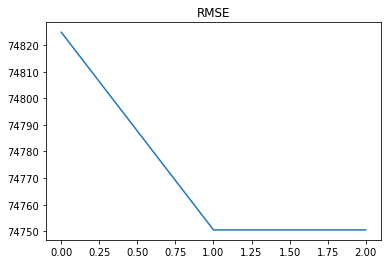

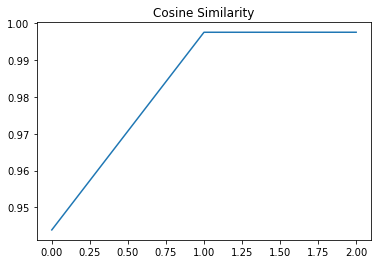

In [4]:
# Save model weight
#checkpoint_path = "../data/cp-{epoch:04d}.ckpt"
#ae_fc[0].save_weights(checkpoint_path.format(epoch=3))

# Visualize the process
%matplotlib inline
import matplotlib.pyplot as plt

print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.title('RMSE')
plt.show()

plt.plot(hist.history['cosine_similarity'])
plt.title('Cosine Similarity')
plt.show()


In [3]:
# Define parameters
datadir = 'D:/worksapce/2020Q3_representation_learning/data/noaa'
finfo = list_noaagridsatb1_files(datadir)
print(finfo.head())
print()

NX = 858
NY = 858
batch_size = 8

# Convolutional AE
ae_conv = initialize_conv_autoencoder_noaagridsatb1((NY, NX, 1))
# Debug info
nSample = finfo.shape[0]
print(ae_conv[0].summary())
print("Training autoencoder with data size: "+str(nSample))
steps_train = np.ceil(nSample/batch_size)
print("Training data steps: " + str(steps_train))
# Fitting model
hist_conv = ae_conv[0].fit(data_generator_ae(finfo['xuri'], batch_size, add_dim=True), steps_per_epoch=steps_train, epochs=3, max_queue_size=batch_size, use_multiprocessing=False, verbose=1)



       timestamp                                               xuri
0  2015.06.01.00  D:/worksapce/2020Q3_representation_learning/da...
1  2015.06.01.03  D:/worksapce/2020Q3_representation_learning/da...
2  2015.06.01.06  D:/worksapce/2020Q3_representation_learning/da...
3  2015.06.01.09  D:/worksapce/2020Q3_representation_learning/da...
4  2015.06.01.12  D:/worksapce/2020Q3_representation_learning/da...

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 858, 858, 1)]     0         
_________________________________________________________________
encoder_conv1 (Conv2D)       (None, 429, 429, 32)      320       
_________________________________________________________________
encoder_conv2 (Conv2D)       (None, 143, 143, 16)      12816     
_________________________________________________________________
encoder_conv3 (Conv2D)       (None, 13, 13, 8)  

dict_keys(['loss', 'cosine_similarity'])


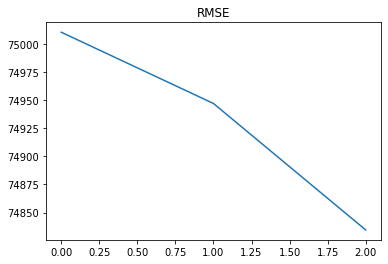

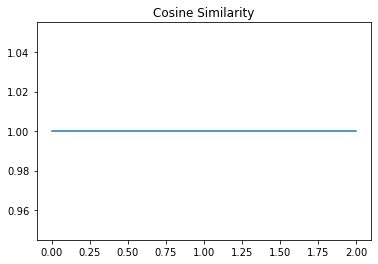

In [4]:
# Save model weight
checkpoint_path = "../data/ae_conv-cp-{epoch:04d}.ckpt"
ae_conv[0].save_weights(checkpoint_path.format(epoch=3))

# Visualize the process
%matplotlib inline
import matplotlib.pyplot as plt

print(hist_conv.history.keys())
plt.plot(hist_conv.history['loss'])
plt.title('RMSE')
plt.show()

plt.plot(hist_conv.history['cosine_similarity'])
plt.title('Cosine Similarity')
plt.show()

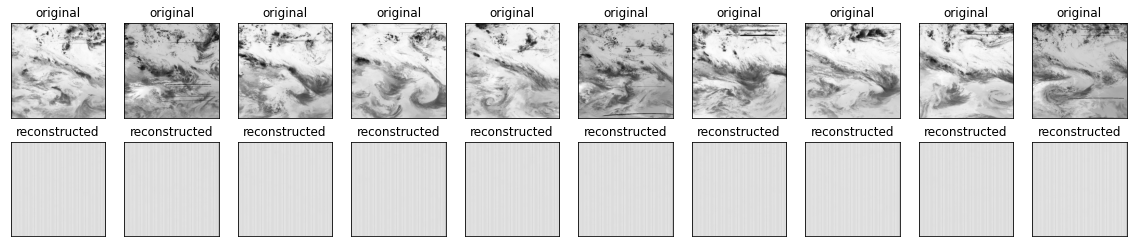

In [5]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Load data
    data = read_noaagridsatb1(finfo['xuri'].iloc[i*10])
    #recon_fc = ae_fc[0](data)
    data3d = np.expand_dims(data, axis=2)
    recon_conv = ae_conv[0](data3d)[:,:,0]
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data)
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_conv)
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()